In [100]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sv
import plotly.graph_objs as pg
import plotly.figure_factory as ffc
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [101]:
 #-----------SPRACOVANIE DAT--------------#

df = pd.read_csv("weather_data.csv")
test_data = pd.read_csv("weather_data.csv")

# najskor pridam do irradiance vsade 0 aby sa neodstranilo prilis vela zaznamov

df["Irradiance"] = df["Irradiance"].fillna(0.0)

# zistili sme ze v nasom datasete sa nachádza 277 null hodnôt okrem (stlpca Irradiance)
# pre dataset nasich rozmerov je to pomerne mali pocet zaznamov a preto sme sa 
# ich rozhodli odstranit
print(f"There are: {df.isnull().sum().sum()} null values in dataset")

# Konvertovanie stĺpca 'UV Index' na číselný typ
df['UV Index'] = pd.to_numeric(df['UV Index'], errors='coerce')


print(df.isnull().sum())

# odstranenie prazdnych zaznamov
df = df.dropna()
df = df.drop_duplicates(keep='first')
df = df.fillna(0)

df = df.drop('Irradiance', axis=1)


There are: 277 null values in dataset
Temperature             44
Humidity                35
Wind Speed              38
Precipitation (%)       33
Cloud Cover              0
Atmospheric Pressure    44
UV Index                37
Season                   0
Visibility (km)         47
Location                 0
Weather Type             0
Irradiance               0
dtype: int64


In [102]:
# zistenie kolko roznych druhov Cloud Cover sa nachadza v DB a ich zakodovnie
# Cloud Cover sme si vybrali druh kodovanie: Label Encoding 

unique_values_cloud = df['Cloud Cover'].unique()
print(f"Unique words: {unique_values_cloud}")
print(f"Number of unique words cloud: {len(unique_values_cloud)}")

df['Cloud Cover'] = pd.factorize(df['Cloud Cover'])[0]

unique_values_location = df['Location'].unique()
print(f"Unique words: {unique_values_location}")
print(f"Number of unique words location: {len(unique_values_location)}")

df['Location'] = pd.factorize(df['Location'])[0]

# na stlpec season sme vybrali druh zakódovania One-Hot Encoding

df_one_hot = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, df_one_hot], axis = 1)

df = df.drop(columns=['Season'])


df['Season_Winter'] = pd.to_numeric(df['Season_Winter'], errors='coerce')
df['Season_Summer'] = pd.to_numeric(df['Season_Summer'], errors='coerce')
df['Season_Autumn'] = pd.to_numeric(df['Season_Autumn'], errors='coerce')
df['Season_Spring'] = pd.to_numeric(df['Season_Spring'], errors='coerce')

# Zobrazenie dátových typov každého stĺpca
print(df.dtypes)

# Vyfiltrovanie stĺpcov, ktoré nie sú číselného typu (float alebo int)
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
print("Stĺpce, ktoré nie sú číselného typu:", non_numeric_columns)



Unique words: ['partly cloudy' 'clear' 'overcast' 'cloudy']
Number of unique words cloud: 4
Unique words: ['inland' 'mountain' 'coastal' 'island']
Number of unique words location: 4
Temperature             float64
Humidity                float64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover               int64
Atmospheric Pressure    float64
UV Index                float64
Visibility (km)         float64
Location                  int64
Weather Type             object
Season_Autumn             uint8
Season_Spring             uint8
Season_Summer             uint8
Season_Winter             uint8
dtype: object
Stĺpce, ktoré nie sú číselného typu: Index(['Weather Type', 'Season_Autumn', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object')


In [103]:
# Vyhľadanie duplicitných záznamov

duplicate = df[df.duplicated()]
df = df.drop_duplicates()
print("Number of records in dataset: "+str(len(df)))
print("There are: " + str(len(duplicate)) + " duplicates.")



Number of records in dataset: 12924
There are: 0 duplicates.


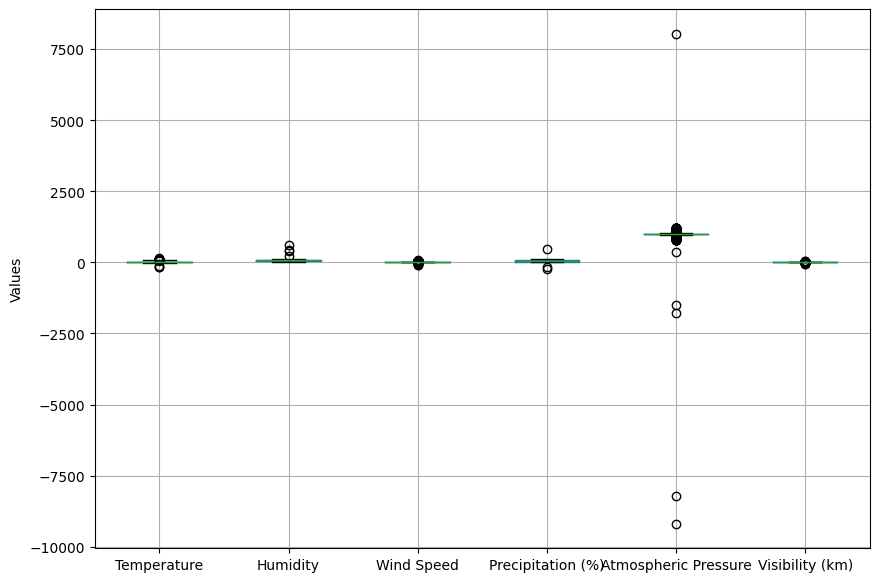

In [104]:
# Teraz potrebujeme odstrániť outliery v stĺpcos v ktorých boli originálne numerické hodnoty

numeric_columns = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'
                  ]

# vypisanie hodnot ako boxplot
df.boxplot(column=['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)'
                   , 'Atmospheric Pressure', 'Visibility (km)'],figsize=(10,7))
plt.ylabel("Values")
plt.show()

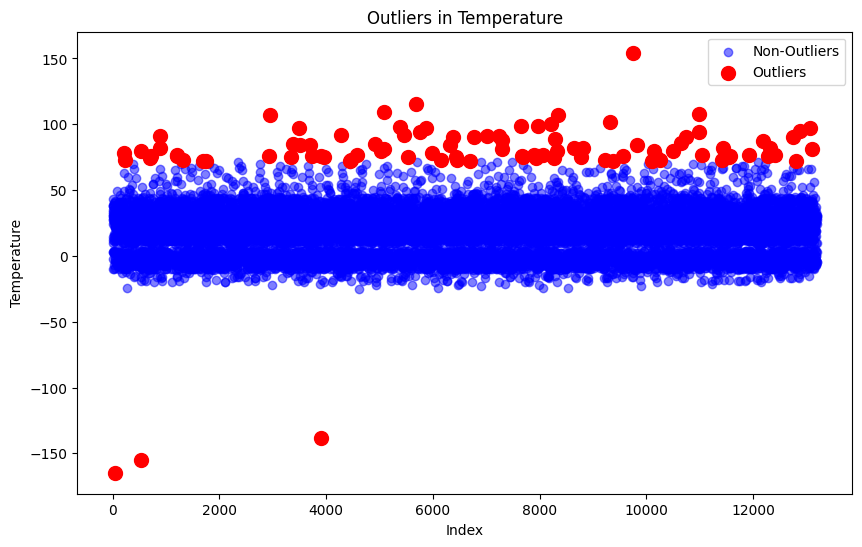

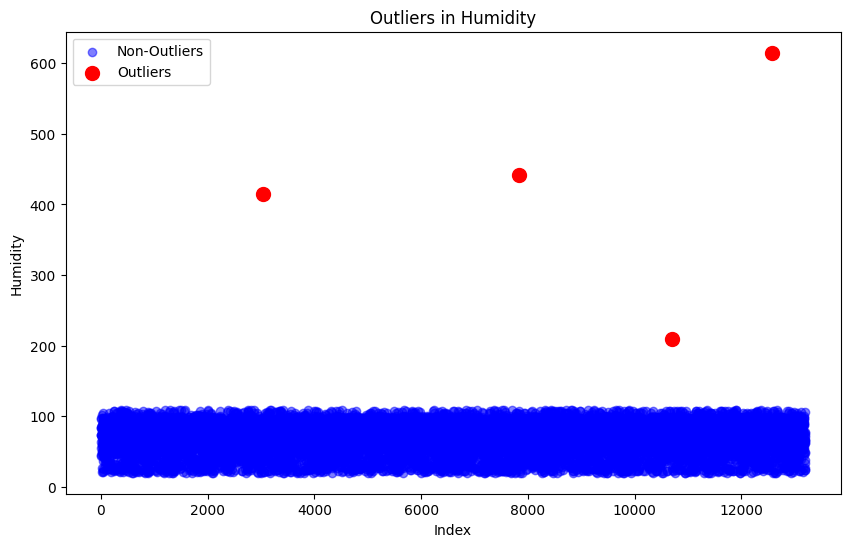

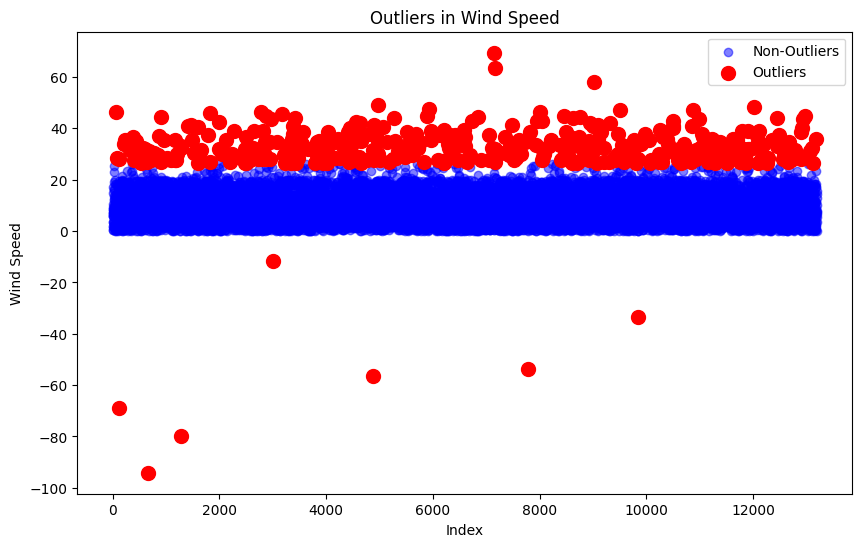

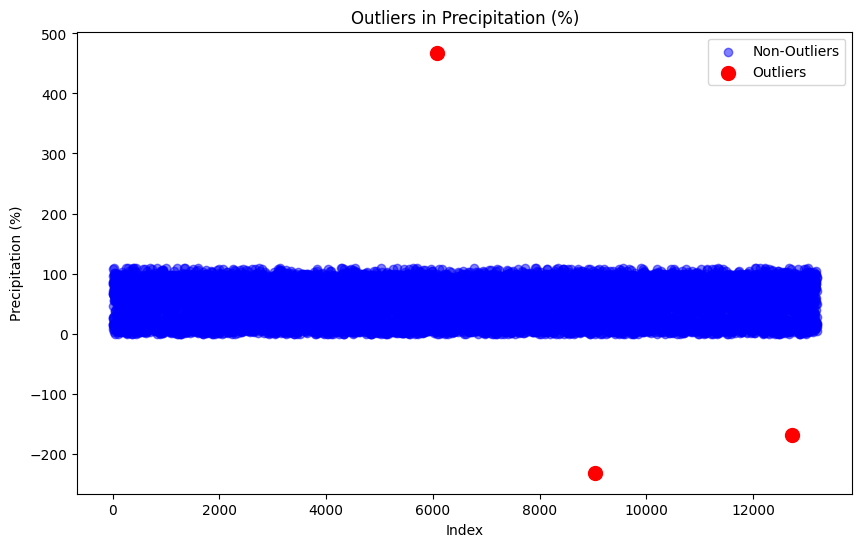

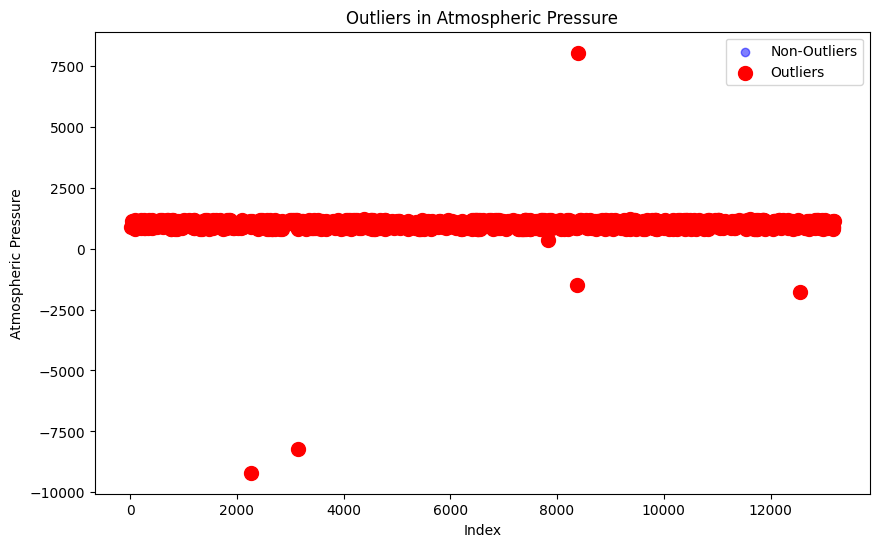

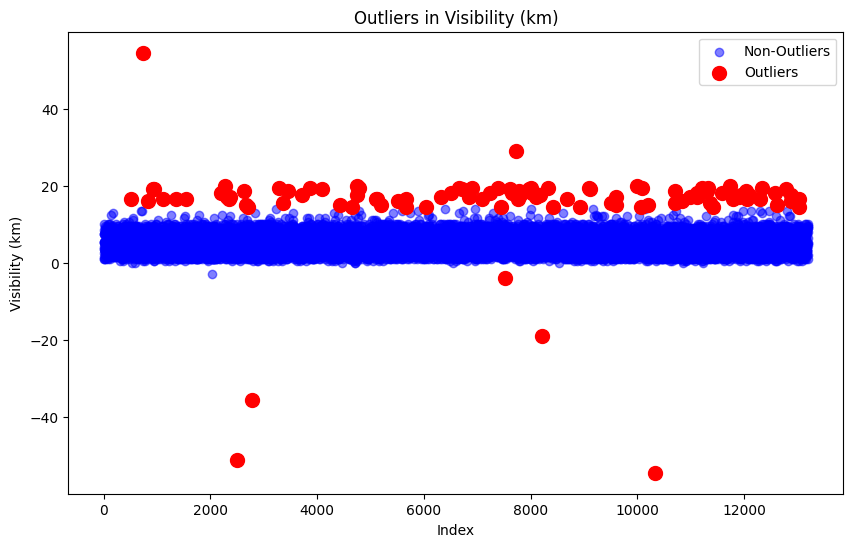

        Temperature      Humidity    Wind Speed  Precipitation (%)  \
count  11103.000000  11103.000000  11103.000000       11103.000000   
mean      18.945778     69.004864      9.116545          50.973460   
std       15.680294     19.115083      5.531784          31.715426   
min      -24.000000     20.000000      0.000000           0.000000   
25%        7.000000     59.000000      5.000000          18.000000   
50%       22.000000     70.000000      8.500000          54.000000   
75%       30.000000     83.000000     13.000000          80.000000   
max       71.000000    100.000000     26.000000         100.000000   

        Cloud Cover  Atmospheric Pressure      UV Index  Visibility (km)  \
count  11103.000000          11103.000000  11103.000000     11103.000000   
mean       1.128884           1006.235808      3.367829         5.124109   
std        0.905187             12.884447      3.302797         2.592008   
min        0.000000            962.880000      0.000000        -3

In [105]:

# Identifikovanie a odstraňovanie outlierov na základe IQR
def detect_and_remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikácia outlierov
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Odstránenie outlierov
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean, outliers

# Aplikovanie na všetky číselné stĺpce
for column in numeric_columns:
    df, outliers = detect_and_remove_outliers(df, column)
    
    # Vizualizácia výsledkov
    plt.figure(figsize=(10, 6))
    
    plt.scatter(df.index, df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=100)
    
    plt.title(f"Outliers in {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Oprava neplatných hodnôt
df['Humidity'] = df['Humidity'].clip(lower=0, upper=100)
df['Precipitation (%)'] = df['Precipitation (%)'].clip(lower=0, upper=100)
# Odstrániť riadky, kde je UV Index väčší ako realistická maximálna hodnota
df = df[df['UV Index'] <= 11]
df = df[df['UV Index'] >= 0]


# Kontrola dát
print(df.describe())


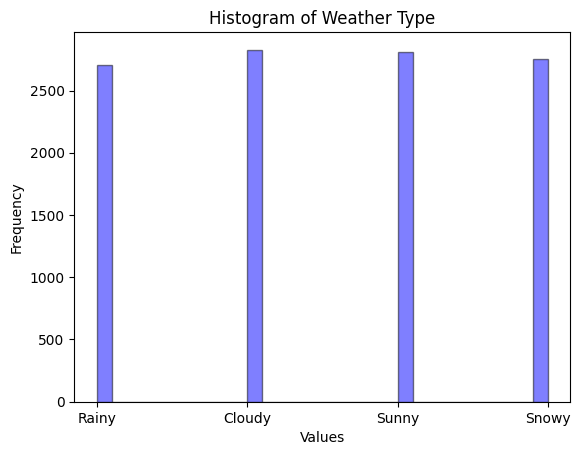

((8882, 13), (8882,), (1110, 13), (1110,), (1111, 13), (1111,))

In [106]:
X = df.drop(columns='Weather Type')
Y = df['Weather Type']

# Najprv rozdelíme dáta na trénovaciu a testovaciu množinu (60% tréning, 40% test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

# Potom rozdelíme trénovaciu množinu na tréningovú a validačnú množinu (50% tréning, 50% validačná)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp , Y_temp, test_size=0.50, random_state=42)

plt.hist(df['Weather Type'], bins=30, color='blue', edgecolor='black', alpha=0.5)

plt.title('Histogram of Weather Type')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.show()

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

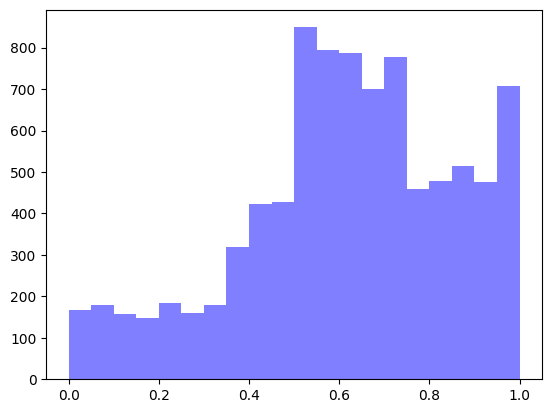

In [107]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train)

plt.hist(X_train_df[1], bins = 20, color = 'blue', alpha = 0.5)
plt.show()

model accuracy: 0.9414941494149415


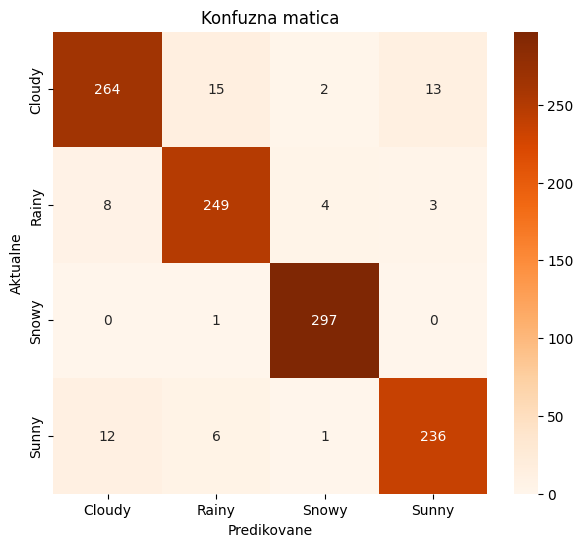

In [108]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

accurracy = accuracy_score(Y_test, y_pred)
print(f"model accuracy: {accurracy}")

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Konfuzna matica")
plt.xlabel("Predikovane")
plt.ylabel("Aktualne")
plt.show()

# 60-20-20 model accuracy: 0.9302937308198159
# 70-15-15 model accuracy: 0.9298655756867329
# 50-25-25 model accuracy: 0.9284712482468443
# 80-10-10 model accuracy: 0.9414941494149415





In [109]:
# korelacna matica
corr_matrix = px.imshow(df.corr())
corr_matrix.show()

C:\Users\mraff\AppData\Local\Temp\ipykernel_25352\2365527316.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



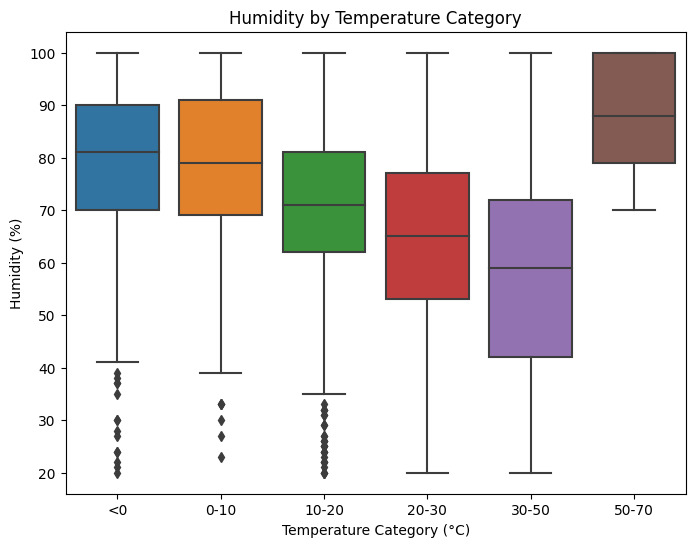

In [110]:
# 1. Teplota vs. Vlhkosť (box plot)

# Rozdelenie teploty do kategórií
df['Temperature Category'] = pd.cut(df['Temperature'], bins=[-30, 0, 10, 20, 30, 50, 70], labels=['<0', '0-10', '10-20', '20-30', '30-50', '50-70'])

plt.figure(figsize=(8,6))
sns.boxplot(x='Temperature Category', y='Humidity', data=df)
plt.title('Humidity by Temperature Category')
plt.xlabel('Temperature Category (°C)')
plt.ylabel('Humidity (%)')
plt.show()



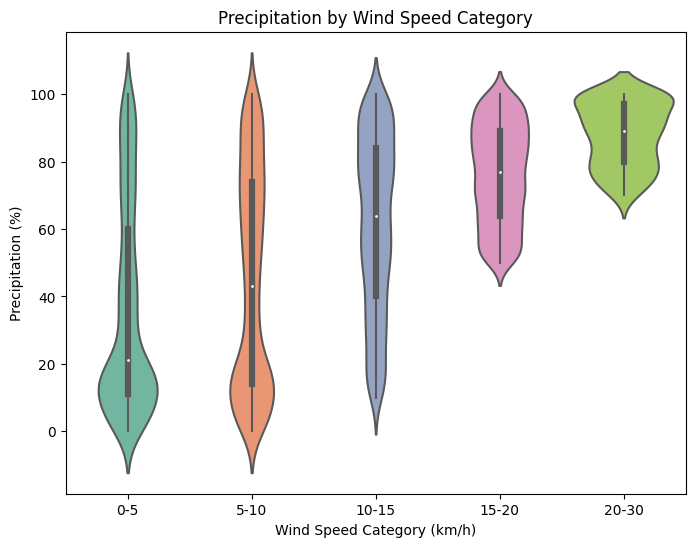

In [111]:
# 2. Vietor a Zrážky (violin plot)

df['Wind Speed Category'] = pd.cut(df['Wind Speed'], bins=[0, 5, 10, 15, 20, 30], labels=['0-5', '5-10', '10-15', '15-20', '20-30'])

plt.figure(figsize=(8,6))
sns.violinplot(x='Wind Speed Category', y='Precipitation (%)', data=df, palette='Set2')
plt.title('Precipitation by Wind Speed Category')
plt.xlabel('Wind Speed Category (km/h)')
plt.ylabel('Precipitation (%)')
plt.show()



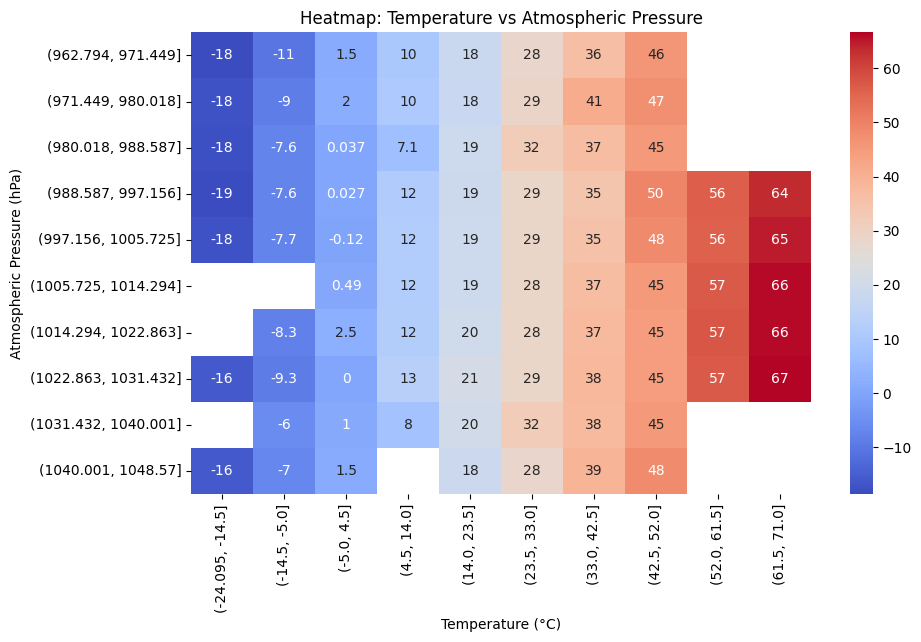

In [112]:
# 3. Atmosférický tlak vs. Teplota (heatmapa)

# Vytvárame mriežku pre atmosférický tlak a teplotu
pressure_temp = pd.pivot_table(df, values='Temperature', index=pd.cut(df['Atmospheric Pressure'], bins=10), columns=pd.cut(df['Temperature'], bins=10), aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(pressure_temp, cmap='coolwarm', annot=True)
plt.title('Heatmap: Temperature vs Atmospheric Pressure')
plt.xlabel('Temperature (°C)')
plt.ylabel('Atmospheric Pressure (hPa)')
plt.show()


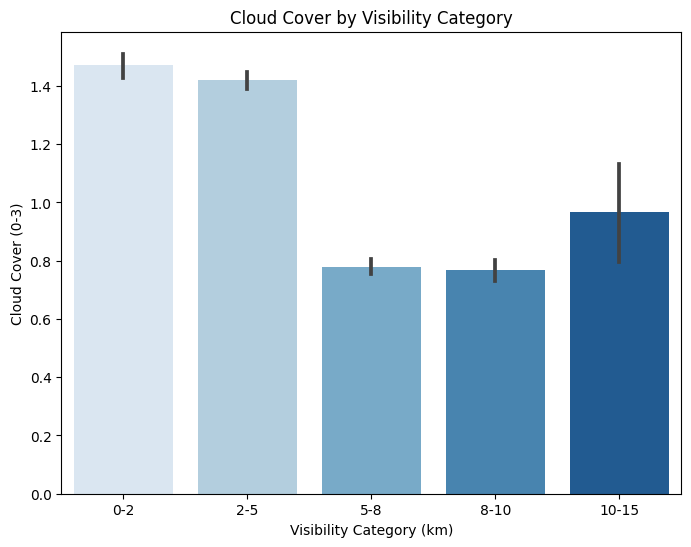

In [113]:
# 4. Oblačnosť vs. Viditeľnosť (bar plot)

# Rozdelenie viditeľnosti do kategórií
df['Visibility Category'] = pd.cut(df['Visibility (km)'], bins=[0, 2, 5, 8, 10, 15], labels=['0-2', '2-5', '5-8', '8-10', '10-15'])

plt.figure(figsize=(8,6))
sns.barplot(x='Visibility Category', y='Cloud Cover', data=df, palette='Blues')
plt.title('Cloud Cover by Visibility Category')
plt.xlabel('Visibility Category (km)')
plt.ylabel('Cloud Cover (0-3)')
plt.show()

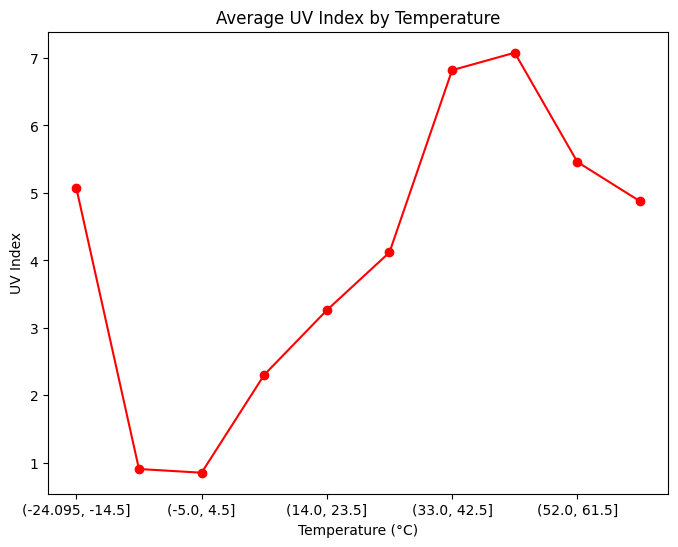

In [114]:
# 5. Teplota a UV Index (line plot)

# Priemerný UV Index pre teplotné kategórie
temp_uv = df.groupby(pd.cut(df['Temperature'], bins=10))['UV Index'].mean()

plt.figure(figsize=(8,6))
temp_uv.plot(kind='line', marker='o', color='red')
plt.title('Average UV Index by Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('UV Index')
plt.show()




In [121]:
# 1. Vytvorenie modelu a pretrénovanie
# Prevod Y na binárny formát
Y_train = pd.get_dummies(Y_train).values  # Konvertuje na binárny formát
Y_val = pd.get_dummies(Y_val).values
Y_test = pd.get_dummies(Y_test).values

# Kontrola tvaru Y
print(Y_train.shape)  # Tvar by mal byť (n_samples, n_classes)
print(Y_val.shape)
print(Y_test.shape)


ValueError: Data must be 1-dimensional

Epoch 1/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6491 - loss: 0.9549 - val_accuracy: 0.8802 - val_loss: 0.4140
Epoch 2/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.9125 - loss: 0.3500 - val_accuracy: 0.9261 - val_loss: 0.3070
Epoch 3/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.9292 - loss: 0.2778 - val_accuracy: 0.9360 - val_loss: 0.2538
Epoch 4/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.9373 - loss: 0.2504 - val_accuracy: 0.9486 - val_loss: 0.2186
Epoch 5/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9473 - loss: 0.2017 - val_accuracy: 0.9505 - val_loss: 0.2006
Epoch 6/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.9458 - loss: 0.1921 - val_accuracy: 0.9541 - val_loss: 0.1799
Epoch 7/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9541 - loss: 0.1730 - val_accuracy: 0.9450 - val_loss: 0.1883
Epoch 8/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.9584 - loss: 0.1573 - val_

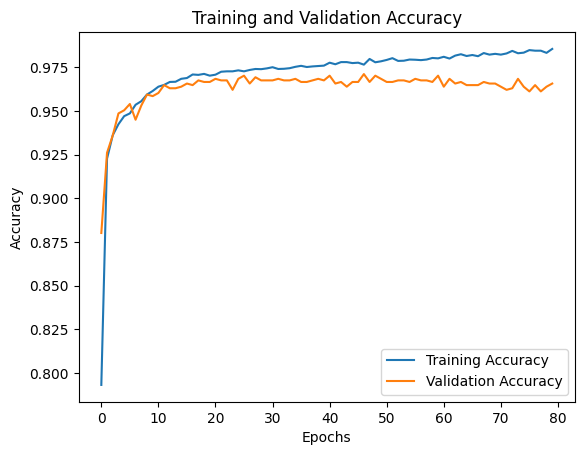

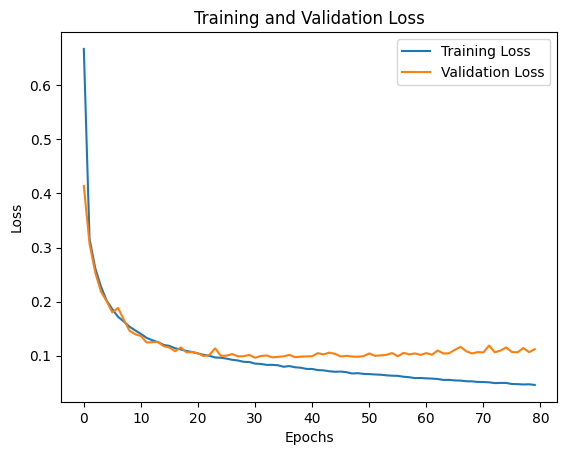

In [122]:

# Definícia modelu
def create_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    
    # Kompilácia modelu
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

# Trénovanie modelu
history = model.fit(X_train, Y_train, epochs=80, validation_data=(X_val, Y_val), batch_size=32)

# Zobrazenie priebehu trénovania
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Zobrazenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [123]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.9680 - loss: 0.0745
Test accuracy: 0.9720972180366516


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step


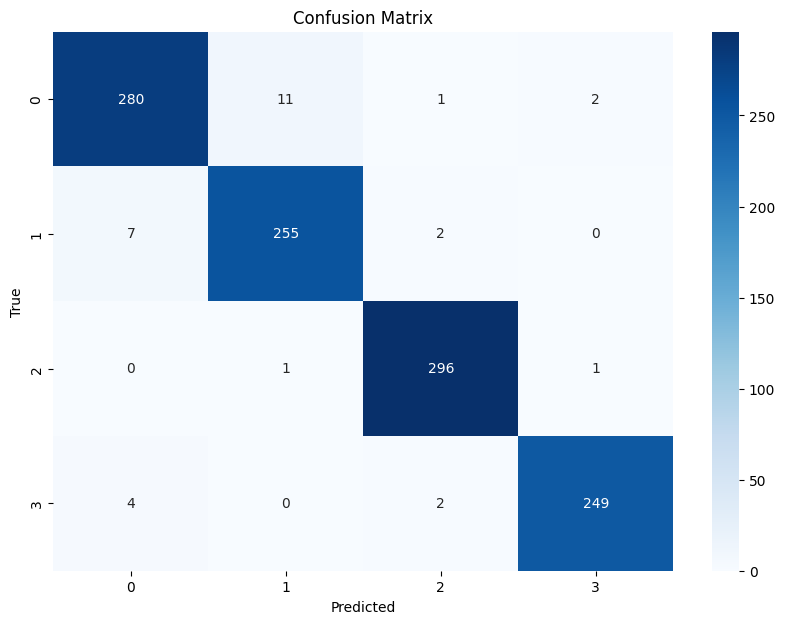

In [128]:
# Predpoveď na testovacích dátach
Y_pred = model.predict(X_test)
Y_pred_classes = Y_pred.argmax(axis=1)
Y_true = Y_test.argmax(axis=1)

# Vytvorenie konfúznej matice
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Vizuálne zobrazenie konfúznej matice
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Epoch 1/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6615 - loss: 0.9657 - val_accuracy: 0.8964 - val_loss: 0.3867
Epoch 2/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9233 - loss: 0.3179 - val_accuracy: 0.9198 - val_loss: 0.2927
Epoch 3/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.9312 - loss: 0.2627 - val_accuracy: 0.9351 - val_loss: 0.2532
Epoch 4/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9378 - loss: 0.2262 - val_accuracy: 0.9333 - val_loss: 0.2237
Epoch 5/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.9420 - loss: 0.1924 - val_accuracy: 0.9387 - val_loss: 0.2059
Epoch 6/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.9442 - loss: 0.1920 - val_accuracy: 0.9505 - val_loss: 0.1871
Epoch 7/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.9458 - loss: 0.1827 - val_accuracy: 0.9459 - val_loss: 0.1861
Epoch 8/80
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9563 - loss: 0.1548 - val_ac

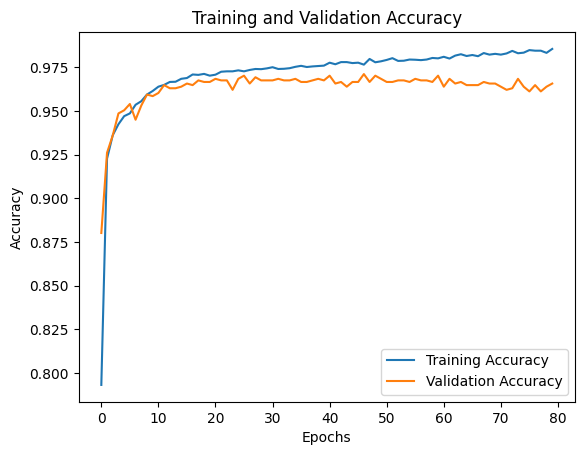

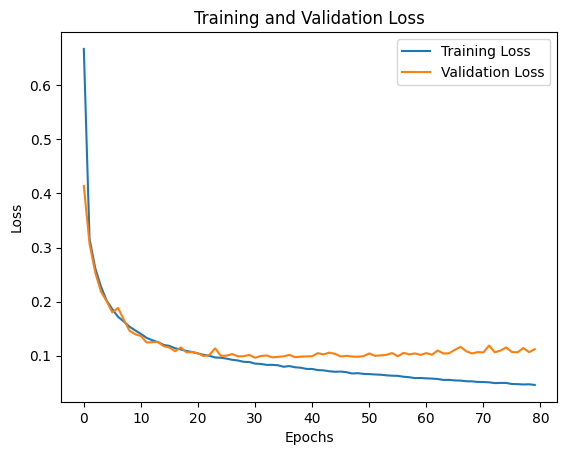

In [127]:
# EarlyStopping zavedenie

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trénovanie s EarlyStopping
model_early = create_model()
history_early = model_early.fit(X_train, Y_train, epochs=80, validation_data=(X_val, Y_val), batch_size=32, callbacks=[early_stopping])

# Zobrazenie priebehu trénovania
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Zobrazenie straty
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


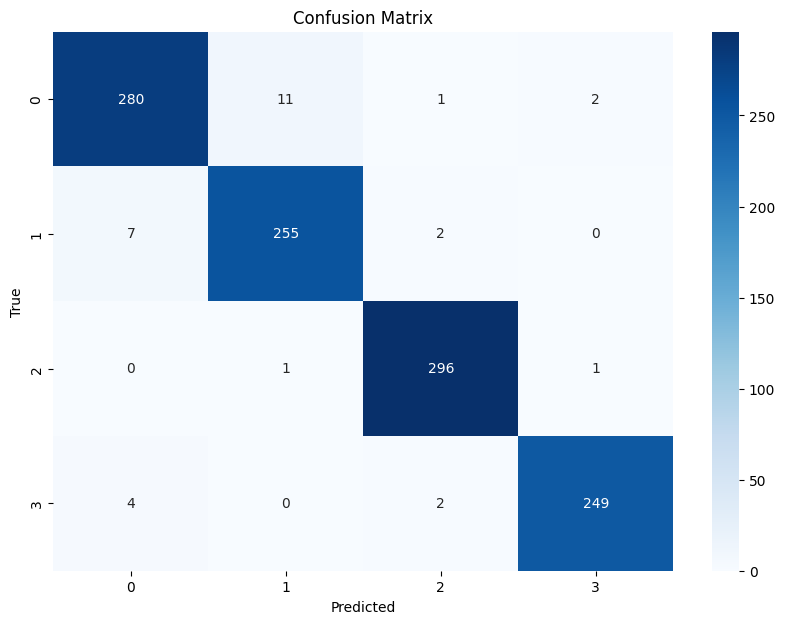

In [129]:
# Predpoveď na testovacích dátach
Y_pred = model.predict(X_test)
Y_pred_classes = Y_pred.argmax(axis=1)
Y_true = Y_test.argmax(axis=1)

# Vytvorenie konfúznej matice
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Vizuálne zobrazenie konfúznej matice
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [130]:
# Experimentovanie

# Experiment 1: Zmena learning rate
model_exp1 = create_model()
model_exp1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_exp1 = model_exp1.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), batch_size=32)

# Experiment 2: Zvýšenie počtu neurónov
model_exp2 = Sequential()
model_exp2.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model_exp2.add(Dense(64, activation='relu'))
model_exp2.add(Dense(Y_train.shape[1], activation='softmax'))
model_exp2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_exp2 = model_exp2.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), batch_size=32)


Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3473 - loss: 1.3368 - val_accuracy: 0.7486 - val_loss: 1.1524
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7735 - loss: 1.0745 - val_accuracy: 0.7901 - val_loss: 0.8769
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.8324 - loss: 0.8129 - val_accuracy: 0.8198 - val_loss: 0.6894
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.8572 - loss: 0.6311 - val_accuracy: 0.8441 - val_loss: 0.5814
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.8763 - loss: 0.5329 - val_accuracy: 0.8613 - val_loss: 0.5128
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.8861 - loss: 0.4726 - val_accuracy: 0.8712 - val_loss: 0.4667
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8997 - loss: 0.4255 - val_accuracy: 0.8784 - val_loss: 0.4333
Epoch 8/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.9067 - loss: 0.3925 - val_accuracy: 0

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9680 - loss: 0.0745 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


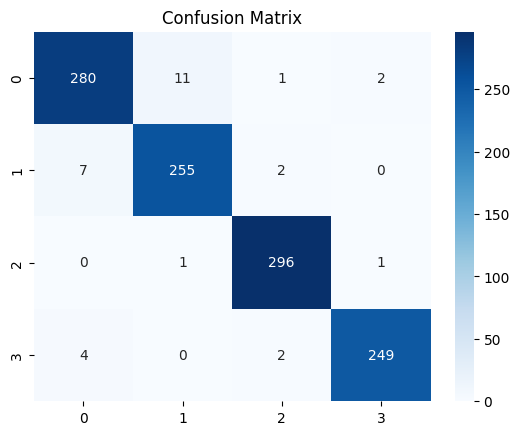

In [131]:
# Vyhodnotenie modelu
test_loss, test_acc = model.evaluate(X_test, Y_test)

# Konfúzna matica
Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

# Zobrazenie konfúznej matice
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()